<a href="https://colab.research.google.com/github/masadeghi/EHRsample/blob/main/nn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import dependencies**

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

# **Import data**

1. Download the data from this link (You'll need to sign up in the PhysioNet website and sign a data use agreement.'): https://physionet.org/content/heart-failure-zigong/1.3/#files
2. Upload the .zip file to your google drive. (Here, I've uploaded the file to a folder named "databases" in my Google drive)
3. Read the datasets into pandas dataframes.

In [2]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Unzip the .zip file containing all the datasets
!unzip gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip

Archive:  gdrive/MyDrive/databases/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3.zip
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/LICENSE.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/SHA256SUMS.txt  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv  
  inflating: hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv  


In [2]:
# Read the datasets into pandas dataframes
patient_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat.csv', index_col = 0)
treatment_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dat_md.csv', index_col = 0)
dict_data = pd.read_csv('/content/hospitalized-patients-with-heart-failure-integrating-electronic-healthcare-records-and-external-outcome-data-1.3/dataDictionary.csv', index_col = 0)

# **Exploratory data analysis and feature engineering**

## Step 1: Restructure the treatment data
One-hot encode the `treatment_data` dataset so that treatment data (drugs administered to the patients during their hospitalization) could be concatenated with the clinical and lab data (`patient_data` dataset).

In [3]:
# Initialize zeros matrix with desired dimensions, indexes, and column names
drugs = np.zeros((len(patient_data['inpatient.number'].unique()),
                  len(treatment_data['Drug_name'].unique())))

drugs = pd.DataFrame(drugs, index = patient_data['inpatient.number'].unique(), columns = treatment_data['Drug_name'].unique())

# Iterate over the rows and columns of the constructed matrix and repalce 0 with 1
# in the appropriate column if the treatment was administered.
for index, row in drugs.iterrows():
  for col in drugs.columns:
    subset = treatment_data.loc[treatment_data['inpatient.number'] == index, 'Drug_name']
    if col in subset.values:
      drugs.loc[index, col] = 1

# Concatenate the resulting matrix with the main dataset:
# Total data (t_data) = main dataset + drug data
patient_data.set_index('inpatient.number', inplace = True)

t_data = pd.concat([patient_data, drugs], axis = 1)

## Step 2: Explore the features

* Identify features with missing data.
* Explore each feature to understand its data structure.

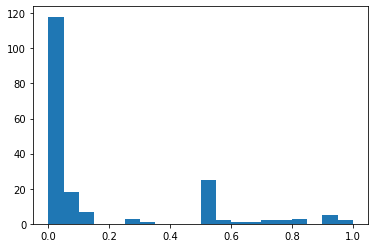

In [4]:
# Determining the extent of missing data in the dataset
missing_perc = []

for i, col in enumerate(t_data.columns):
  percentage = t_data[col].isnull().mean()
  missing_perc.append((i, col, percentage))

missing_perc.sort(key = lambda x: x[2], reverse = True)

plt.hist([i[2] for i in missing_perc], bins = 20)
plt.show()

In [5]:
# Explore each variable
def summary(colname):
  col = t_data[colname]

  print(col[:5])

  if col.dtype == object:
    print('\n Unique factors: \n', col.unique())
    print('\n', col.describe(include = 'object'))
  else:
    print('\n', col.describe())

summary("dischargeDay")

857781    11
743087     8
866418     5
775928    11
810128     5
Name: dischargeDay, dtype: int64

 count    2008.000000
mean        9.420817
std         8.030256
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max       123.000000
Name: dischargeDay, dtype: float64


## Step 3: Split data into predictor (`X`) and target (`y`) datasets
* Log transform `y` to make it's distribution closer to normal.

In [6]:
y = t_data['dischargeDay']
X = t_data.drop('dischargeDay', axis = 1)

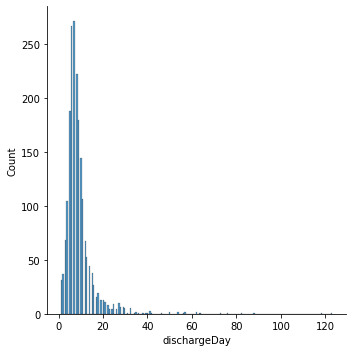

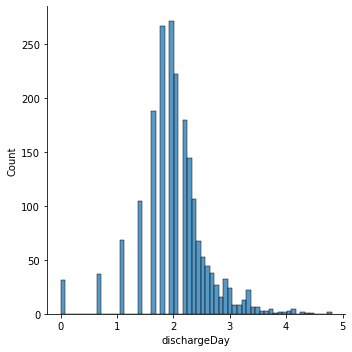

In [7]:
# log transform y
import seaborn as sns
sns.displot(y)
y = np.log(y)
sns.displot(y)

## Step 4: Remove features that aren't useful in a practical setting
Explore the features in `X` to classify them into the following categories:

*   Features that are expected to be available at the time of admission or a short while after (e.g., preliminary lab data)
*   Features that are expected to be available only at the time of discharge
*   Features from echocardiography
*   Features that are expected to be available only after patient discharge and on patient follow-up

For predicting duration of hospital stay, only the first category could be useful in a clinical setting.

In [8]:
# Features only availble at the time of discharge
discharge_var = ['DestinationDischarge', 'discharge.department', 'outcome.during.hospitalization']

# Features only available after discharge and on patient follow-up
future_var = ['death.within.28.days', 're.admission.within.28.days', 'death.within.3.months',
              're.admission.within.3.months', 'death.within.6.months', 're.admission.within.6.months',
              'time.of.death..days.from.admission.', 're.admission.time..days.from.admission.',
              'return.to.emergency.department.within.6.months', 'time.to.emergency.department.within.6.months']

# Features only available after an echocardiography
echo_var = ['LVEF', 'left.ventricular.end.diastolic.diameter.LV',
            'mitral.valve.EMS', 'mitral.valve.AMS', 'EA',
            'tricuspid.valve.return.velocity', 'tricuspid.valve.return.pressure']

# Remove future_var and discharge_var from X
X = X.drop(discharge_var + future_var, axis = 1)

## Step 5: Remove features with too many missing values

In [9]:
# Remove features with more than 20% missing data
keepers = [True] * len(X.columns)

for i, col in enumerate(X.columns):
  if X[col].isnull().mean() > 0.2: # This also removes all echo_vars
    keepers[i] = False

X = X.loc[:, keepers]

## Step 6: Convert ordered categorical features to numerical encodings
e.g., NYHA classification could be represented as 1.0 to 4.0 to indicate increasing severity of heart failure.

In [10]:
convert_ordered = {'NYHA.cardiac.function.classification': {'II': 2, 'III': 3, 'IV': 4},
                   'Killip.grade': {'I': 1, 'II': 2, 'III': 3, 'IV': 4},
                   'consciousness': {'Clear': 0, 'ResponsiveToSound': 1, 'ResponsiveToPain': 2, 'Nonresponsive': 3},
                   'respiratory.support.': {'None': 0, 'NIMV': 1, 'IMV': 2},
                   'ageCat': {'(21,29]': 0, '(29,39]': 1, '(39,49]': 2, '(49,59]': 3, '(59,69]': 4, '(69,79]': 5, '(79,89]': 6, '(89,110]': 7}
}

X = X.replace(convert_ordered)

# **Prepare data for input into the model**
1. Divide data into continuous and categorical features.
2. Split data into train/test datasets.
2. Impute missing values using values inferred from train datasets.
3. Normalize continuous features using values inferred from train datasets.
4. Convert datasets to torch tensors.

## Step 1: Divide data into continuous and categorical features

In [11]:
# Categorical features
patient_id_and_clinic = ['admission.ward', 'admission.way', 'occupation', 'gender', 'type.of.heart.failure',
                         'oxygen.inhalation', 'type.II.respiratory.failure', 'acute.renal.failure']

past_medical_history = ['myocardial.infarction', 'congestive.heart.failure', 'peripheral.vascular.disease',
                        'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease', 
                        'connective.tissue.disease', 'peptic.ulcer.disease', 'diabetes',
                        'moderate.to.severe.chronic.kidney.disease', 'hemiplegia', 'leukemia',
                        'malignant.lymphoma', 'solid.tumor', 'liver.disease', 'AIDS']
                       
treatments = ['sulfotanshinone sodium injection', 'Furosemide tablet', 'Enoxaparin Sodium injection',
              'Meglumine Adenosine Cyclophosphate for injection', 'Furosemide injection', 'Milrinone injection',
              'Metoprolol Succinate Sustained-release tablet', 'Deslanoside injection', 'Torasemide tablet',
              'Benazepril hydrochloride tablet', 'Atorvastatin calcium tablet', 'Aspirin enteric-coated tablet',
              'Digoxin tablet', 'Hydrochlorothiazide tablet', 'metoprolol tartrate injection',
              'Spironolactone tablet', 'Valsartan Dispersible tablet', 'Dobutamine hydrochloride injection',
              'Clopidogrel Hydrogen Sulphate tablet', 'Isoprenaline Hydrochloride injection', 'Nitroglycerin injection',
              'Shenfu injection', 'Isosorbide Mononitrate Sustained Release tablet', 'warfarin sodium tablet',
              'Heparin Sodium injection']

categorical_columns = patient_id_and_clinic + past_medical_history + treatments

categorical_features = X[categorical_columns]

In [12]:
# Continuous features
continuous_columns = list(set(X.columns) - set(categorical_columns))

continuous_features = X[continuous_columns]

## Step 2: Split data into train/test datasets

In [13]:
no_examples = len(y)

indexes = list(range(no_examples))

random.seed(50)
random.shuffle(indexes)

train_indexes = indexes[:int(0.8 * no_examples)]
test_indexes = indexes[int(0.8 * no_examples):]

X_train_cont = continuous_features.iloc[train_indexes, :]
X_train_cat = categorical_features.iloc[train_indexes, :]
y_train = y.values[train_indexes]

X_test_cont = continuous_features.iloc[test_indexes, :]
X_test_cat = categorical_features.iloc[test_indexes, :]
y_test = y.values[test_indexes]

## Step 3: Impute missing data
* Replace NAs with the feature mode for categorical variables (`dtype = 'category'`).
* Replace NAs in continuous features (`dtype = 'float64'`) with column median.

In [14]:
imp_cont = SimpleImputer(missing_values = np.nan, strategy = 'median')
X_train_cont = imp_cont.fit_transform(X_train_cont)
X_test_cont = imp_cont.transform(X_test_cont)

imp_cat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_train_cat = imp_cat.fit_transform(X_train_cat)
X_test_cat = imp_cat.transform(X_test_cat)

## Step 4: Normalize continuous features

In [15]:
scaler = MinMaxScaler()

X_train_cont = scaler.fit_transform(X_train_cont)
X_test_cont = scaler.transform(X_test_cont)

## Step 5: Prepare data for input into the model
* Reconvert categorical datasets to pandas dataframes.
* Set `dtype` of categorical variables to `category`
* Convert continuous and categorical features and target data to torch tensors.

In [16]:
# Categorical features
X_train_cat = pd.DataFrame(X_train_cat, columns = categorical_columns)
X_test_cat = pd.DataFrame(X_test_cat, columns = categorical_columns)

X_train_cat[categorical_columns] = X_train_cat[categorical_columns].astype('category')
X_test_cat[categorical_columns] = X_test_cat[categorical_columns].astype('category')

X_train_cat = np.stack([X_train_cat[col].cat.codes.values for col in categorical_columns], axis = 1)
X_test_cat = np.stack([X_test_cat[col].cat.codes.values for col in categorical_columns], axis = 1)

X_train_cat = torch.tensor(X_train_cat, dtype = torch.int64)
X_test_cat = torch.tensor(X_test_cat, dtype = torch.int64)

In [17]:
# Continuous features
X_train_cont = torch.tensor(X_train_cont, dtype = torch.float32)
X_test_cont = torch.tensor(X_test_cont, dtype = torch.float32)

In [18]:
# Target
y_train = torch.tensor(y_train, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test, dtype = torch.float32).reshape(-1, 1)

# Define Model

## Step 1: Set embedding sizes for the categorical features
* The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [19]:
X[categorical_columns] =  X[categorical_columns].astype('category')
cat_szs = [len(X[col].cat.categories) for col in categorical_columns]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs[:5]

[(4, 2), (2, 1), (5, 3), (2, 1), (3, 2)]

## Step 2: Define a TabularModel class

In [20]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

## Step 3: Define the model

In [27]:
model = TabularModel(emb_szs,
                     continuous_features.shape[1],
                     1,
                     [200,100],
                     p=0.4)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [22]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(5, 3)
    (3): Embedding(2, 1)
    (4): Embedding(3, 2)
    (5): Embedding(2, 1)
    (6): Embedding(2, 1)
    (7): Embedding(2, 1)
    (8): Embedding(2, 1)
    (9): Embedding(2, 1)
    (10): Embedding(2, 1)
    (11): Embedding(2, 1)
    (12): Embedding(2, 1)
    (13): Embedding(2, 1)
    (14): Embedding(2, 1)
    (15): Embedding(2, 1)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
    (18): Embedding(2, 1)
    (19): Embedding(1, 1)
    (20): Embedding(2, 1)
    (21): Embedding(2, 1)
    (22): Embedding(2, 1)
    (23): Embedding(2, 1)
    (24): Embedding(2, 1)
    (25): Embedding(2, 1)
    (26): Embedding(2, 1)
    (27): Embedding(2, 1)
    (28): Embedding(2, 1)
    (29): Embedding(2, 1)
    (30): Embedding(2, 1)
    (31): Embedding(2, 1)
    (32): Embedding(2, 1)
    (33): Embedding(2, 1)
    (34): Embedding(2, 1)
    (35): Embedding(2, 1)
    (36): Embedding(2, 1)
    (37): 

# Training the model

## Step 1: train the model

In [28]:
torch.manual_seed(50)

start_time = time.time()

epochs = 1000
train_losses = []
val_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(X_train_cat, X_train_cont)
    loss_train = criterion(y_pred, y_train)
    train_losses.append(loss_train)

    with torch.no_grad():
      y_val = model(X_test_cat, X_test_cont)
      loss_val = criterion(y_val, y_test)
    val_losses.append(loss_val)

    if i % 50 == 1 :
      print(f'epoch: {i:3}  train loss: {loss_train.item():8.4f}      validation loss: {loss_val.item():8.4f}')

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()


print(f'epoch: {i:3}  train loss: {loss_train.item():8.4f}      validation loss: {loss_val.item():8.4f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  train loss:   4.9957      validation loss:   5.2566
epoch:  51  train loss:   3.5346      validation loss:   3.7283
epoch: 101  train loss:   1.8489      validation loss:   2.0165
epoch: 151  train loss:   0.9690      validation loss:   1.1933
epoch: 201  train loss:   0.7242      validation loss:   0.8284
epoch: 251  train loss:   0.6299      validation loss:   0.7742
epoch: 301  train loss:   0.4859      validation loss:   0.7236
epoch: 351  train loss:   0.4727      validation loss:   0.8433
epoch: 401  train loss:   0.4008      validation loss:   0.7181
epoch: 451  train loss:   0.3417      validation loss:   0.6404
epoch: 501  train loss:   0.3550      validation loss:   0.6902
epoch: 551  train loss:   0.3074      validation loss:   0.6092
epoch: 601  train loss:   0.2925      validation loss:   0.6109
epoch: 651  train loss:   0.2651      validation loss:   0.5013
epoch: 701  train loss:   0.2204      validation loss:   0.5393
epoch: 751  train loss:   0.2375      va

## Step 2: Plot loss curves

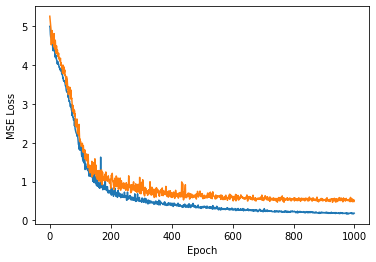

In [29]:
train_losses_np = np.array([i.detach().numpy() for i in train_losses])
val_losses_np = np.array([i.detach().numpy() for i in val_losses])

plt.plot(range(epochs), train_losses_np)
plt.plot(range(epochs), val_losses_np)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch');

## Step 3: Validate the model

In [30]:
with torch.no_grad():
    y_val = model(X_test_cat, X_test_cont)
    loss = criterion(y_val, y_test)

print(f'MSE: {loss:.8f}')

MSE: 0.48846531
